# In this notebook i will implement a decision tree ml algorithm from scratch to better understand how this algorithm works.

I will implement Node and DecisionTree classes

### Node:

The Node class consists of 2 methods:

`__init__` with params left, right - for each of the children, threshold, feature and value that only the leaf nodes have.

`isLeaf` checks if the node is a leaf.

### DecisionTree:

Provides 3 **public** methods:
`__init__` initializes a model with default values:
* min_samples_split = 2
* max_depth = 100
* n_features = None
* task = "classification"

`fit` fits the model given X and y

`predict` makes predictions on a fitted model given an X.


In [1]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, left=None, right=None, threshold=None, feature=None, *, value=None):
        """
        Initialize a single node in a decision tree.

        Args:
            left (Node): Left child of node
            right (Node): Right child of node
            threshold (float): Threshold used for splitting
            feature (int): Feature index used for splitting
            value (float/int): Value predicted by the leaf node (only leaf nodes have value)
        """
        self.left = left
        self.right = right
        self.threshold = threshold
        self.feature = feature
        self.value = value
        
    def isLeaf(self):
        """
        Checks if a node is a leaf node.

        Returns:
            bool: True if the node is a leaf, False otherwise
        """
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None, task="classification"):
        """
        Initialize a decision tree.

        Args:
            min_samples_split (int): Minimum number of samples required to split
            max_depth (int): Maximum depth of the tree
            n_features (int): Number of features to consider when looking for the best split
            task (str): Either "classification" or "regression"
        """
        assert task in ("classification", "regression"), "task must be either 'classification' or 'regression'"
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.task = task

        if task == "classification":
            self._impurity = self._get_entropy
            self._gain = self._get_inf_gain
            self._leaf_value = lambda y: np.bincount(y).argmax()
        else:
            self._impurity = self._variance
            self._gain = self._variance_red
            self._leaf_value = np.mean

    def _grow(self, X, y, depth=0):
        """
        Recursively grows the decision tree.

        Args:
            X (ndarray of shape (m, n)): Feature matrix
            y (ndarray of shape (m,)): Target vector
            depth (int): Current depth of the tree

        Returns:
            Node: The constructed node (leaf or decision node)
        """
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria
        if n_samples < self.min_samples_split or depth >= self.max_depth or n_labels == 1:
            leaf_val = self._leaf_value(y)   
            return Node(value=leaf_val)

        # Find best split
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # Split 
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(left, right, best_thresh, best_feature)

    def _best_split(self, X, y, feat_idxs):
        """
        Finds the best feature index and threshold to split on.

        Args:
            X (ndarray of shape (m, n)): Feature matrix
            y (ndarray of shape (m,)): Target vector
            feat_idxs (ndarray): Indices of features to consider

        Returns:
            tuple: (split_idx, split_threshold)
        """
        best_gain = -1
        split_idx, split_thr = None, None

        for fi in feat_idxs:
            X_column = X[:, fi]
            thresholds = np.unique(X_column)
            for thr in thresholds:
                gain = self._gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = fi
                    split_thr = thr

        return split_idx, split_thr

    def _split(self, X_column, threshold):
        """
        Splits indices of the dataset based on a threshold.

        Args:
            X_column (ndarray of shape (m,)): Feature column
            threshold (float or int): Threshold to split on

        Returns:
            tuple: (left_idxs, right_idxs)
        """
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs

    def _get_inf_gain(self, y, X_column, threshold):
        """
        Computes information gain using entropy (for classification).

        Args:
            y (ndarray of shape (m,)): Target vector
            X_column (ndarray of shape (m,)): Feature column
            threshold (float or int): Threshold to split on

        Returns:
            float: Information gain
        """
        parent_entropy = self._get_entropy(y)
        left_idx, right_idx = self._split(X_column, threshold)

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        e_l = self._get_entropy(y[left_idx])
        e_r = self._get_entropy(y[right_idx])

        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy

    def _get_entropy(self, y):
        """
        Computes entropy of a target vector (for classification).

        Args:
             y (ndarray of shape (m,)): Target vector

        Returns:
             float: Entropy value
        """
        ps = np.bincount(y) / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def fit(self, X, y):
        """
        Fits the decision tree model.

        Args:
            X (ndarray of shape (m, n)): Feature matrix
            y (ndarray of shape (m,)): Target vector
        """
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow(X, y)

    def _traverse(self, x, node):
        """
        Traverses the tree recursively to make a prediction.

        Args:
            x (ndarray of shape (n,)): Single sample
            node (Node): Current node

        Returns:
            float or int: Predicted value
        """
        if node.isLeaf():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        return self._traverse(x, node.right)

    def _variance(self, y):
        """
        Computes the variance (for regression).

        Args:
            y (ndarray of shape (m,)): Target vector

        Returns:
            float: Variance
        """
        return np.var(y)

    def _variance_red(self, y, X_column, threshold):
        """
        Computes variance reduction (for regression).

        Args:
            y (ndarray of shape (m,)): Target vector
            X_column (ndarray of shape (m,)): Feature column
            threshold (float or int): Threshold to split on

        Returns:
            float: Variance reduction
        """
        parent_loss = self._variance(y)
        left_idx, right_idx = self._split(X_column, threshold)

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idx), len(right_idx)
        child_loss = (n_l/n) * self._variance(y[left_idx]) + (n_r/n) * self._variance(y[right_idx])
        return parent_loss - child_loss
    
    def predict(self, X):
        """
        Predicts target values for given samples.

        Args:
            X (ndarray of shape (m, n)): Feature matrix

        Returns:
            ndarray: Predictions for each sample
        """
        return np.array([self._traverse(x, self.root) for x in X])


# Testing

We are testing it on 4 datasets 2 for classification and 2 for regression:

- Iris dataset (classification)
- Wine dataset (classification)
- Diabetes dataset (regression)
- California housing dataset (regression)

In [2]:
# Importing some libraries to use already defined models (the scikit learn versions of the models i implemented)
# some datasets to test them and some metrics to compare them
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

 First we are going to define some helper functions for plotting the results

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_classification_comparison(y_test, y_pred_custom, y_pred_sklearn):
    """
    Plots actual vs predicted counts for two models side by side.

    Args:
        y_test (ndarray): True labels
        y_pred_custom (ndarray): Predicted labels from your model
        y_pred_sklearn (ndarray: Predicted labels from scikit-learn model
    """
    classes = np.unique(y_test)
    n_classes = len(classes)
    x = np.arange(n_classes)

    actual_counts = [np.sum(y_test == c) for c in classes]
    pred_custom_counts = [np.sum(y_pred_custom == c) for c in classes]
    pred_sklearn_counts = [np.sum(y_pred_sklearn == c) for c in classes]

    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Custom model
    axs[0].bar(x - 0.2, actual_counts, width=0.4, label="Actual")
    axs[0].bar(x + 0.2, pred_custom_counts, width=0.4, label="Predicted")
    axs[0].set_xticks(x)
    axs[0].set_xlabel("Class")
    axs[0].set_ylabel("Count")
    axs[0].set_title("Custom Model Predictions")
    axs[0].legend()

    # Sklearn model
    axs[1].bar(x - 0.2, actual_counts, width=0.4, label="Actual")
    axs[1].bar(x + 0.2, pred_sklearn_counts, width=0.4, label="Predicted")
    axs[1].set_xticks(x)
    axs[1].set_xlabel("Class")
    axs[1].set_ylabel("Count")
    axs[1].set_title("Scikit-learn Model Predictions")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


def plot_regression_comparison(y_test, y_pred_custom, y_pred_sklearn):
    """
    Plots predicted vs actual values for two regression models.

    Args:
        y_test (array-like): True target values
        y_pred_custom (array-like): Predicted values from your model
        y_pred_sklearn (array-like): Predicted values from scikit-learn model
    """
    fig, axs = plt.subplots(1, 2, figsize=(12,5))

    # Custom model
    axs[0].scatter(y_test, y_pred_custom, color='blue', alpha=0.6)
    axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)  
    axs[0].set_xlabel("Actual")
    axs[0].set_ylabel("Predicted")
    axs[0].set_title("Custom Regression Predictions")

    # Sklearn model
    axs[1].scatter(y_test, y_pred_sklearn, color='green', alpha=0.6)
    axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2) 
    axs[1].set_xlabel("Actual")
    axs[1].set_ylabel("Predicted")
    axs[1].set_title("Scikit-learn Regression Predictions")

    plt.tight_layout()
    plt.show()



First let's test them on the Iris dataset.

In [4]:
X,y = load_iris(return_X_y = True)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

my_tree = DecisionTree(task = "classification",max_depth = 2)
my_tree.fit(X_train,y_train)
y_pred_my = my_tree.predict(X_test)

sk_tree = DecisionTreeClassifier(max_depth =2)
sk_tree.fit(X_train,y_train)
y_pred_sk = sk_tree.predict(X_test)

print("My Tree Accuracy:", accuracy_score(y_test, y_pred_my))
print("SKLearn Accuracy:", accuracy_score(y_test, y_pred_sk))

My Tree Accuracy: 1.0
SKLearn Accuracy: 1.0


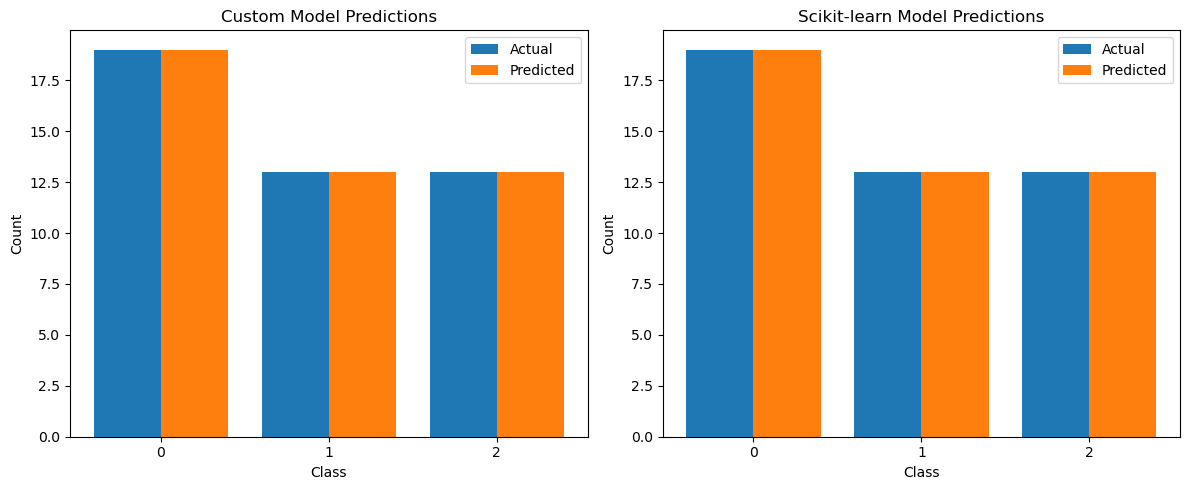

In [5]:
plot_classification_comparison(y_test,y_pred_my,y_pred_sk)

Let's now test it on a bigger dataset (The wine dataset from sklearn)

In [6]:
X,y = load_wine(return_X_y = True)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

my_tree = DecisionTree(task = "classification",max_depth = 3)
my_tree.fit(X_train,y_train)
y_pred_my = my_tree.predict(X_test)

sk_tree = DecisionTreeClassifier(max_depth =3)
sk_tree.fit(X_train,y_train)
y_pred_sk = sk_tree.predict(X_test)

print("My Tree Accuracy:", accuracy_score(y_test, y_pred_my))
print("SKLearn Accuracy:", accuracy_score(y_test, y_pred_sk))

My Tree Accuracy: 0.8148148148148148
SKLearn Accuracy: 0.9629629629629629


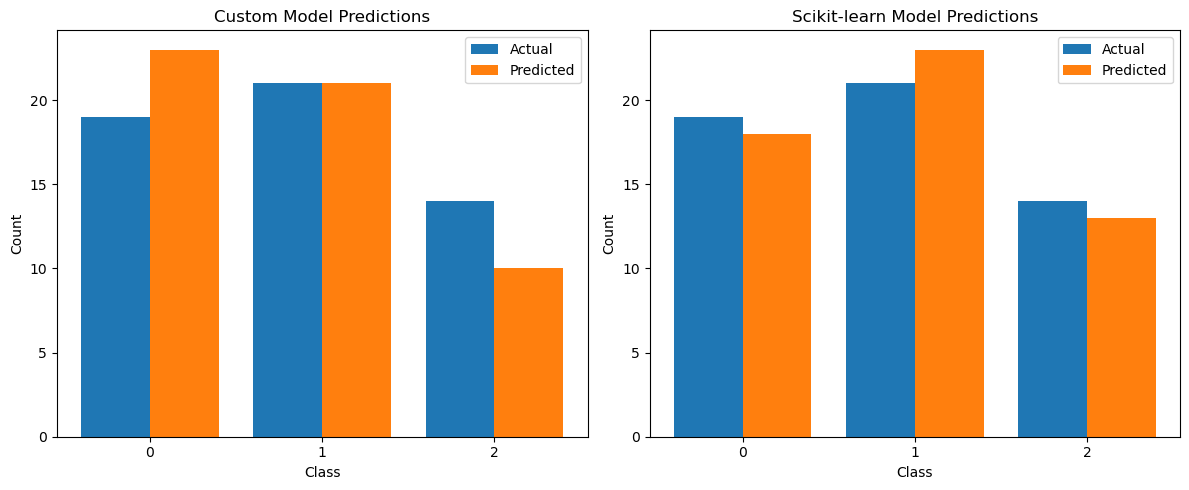

In [7]:
plot_classification_comparison(y_test,y_pred_my,y_pred_sk)

Some tests on regression. First the diabetes dataset.

In [8]:
X,y = load_diabetes(return_X_y = True)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

my_tree = DecisionTree(task = "regression",max_depth = 3)
my_tree.fit(X_train,y_train)
y_pred_my = my_tree.predict(X_test)

sk_tree = DecisionTreeRegressor(max_depth =3)
sk_tree.fit(X_train,y_train)
y_pred_sk = sk_tree.predict(X_test)

print("My Tree MSE:", mean_squared_error(y_test, y_pred_my))
print("SKLearn MSE:", mean_squared_error(y_test, y_pred_sk))

My Tree MSE: 3616.769894653006
SKLearn MSE: 3616.769894653006


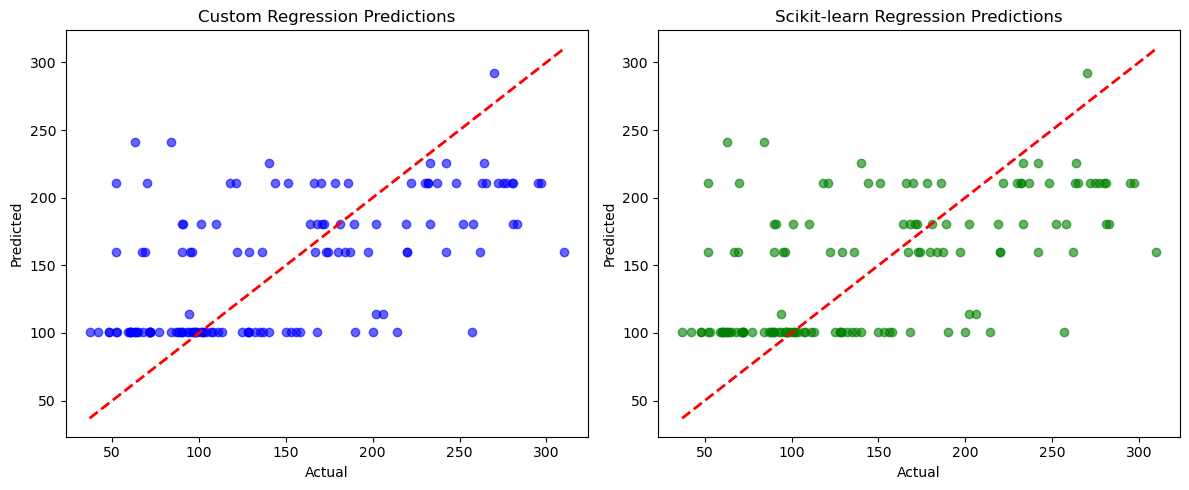

In [9]:
plot_regression_comparison(y_test,y_pred_my,y_pred_sk)

Here is a test on a bigger dataset (the california_housing dataset)

In [11]:
X,y = fetch_california_housing(return_X_y = True)
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

my_tree = DecisionTree(task = "regression",max_depth = 3)
my_tree.fit(X_train,y_train)
y_pred_my = my_tree.predict(X_test)

sk_tree = DecisionTreeRegressor(max_depth =3)
sk_tree.fit(X_train,y_train)
y_pred_sk = sk_tree.predict(X_test)

print("My Tree MSE:", mean_squared_error(y_test, y_pred_my))
print("SKLearn MSE:", mean_squared_error(y_test, y_pred_sk))

My Tree MSE: 0.632483803107781
SKLearn MSE: 0.6325363214073455


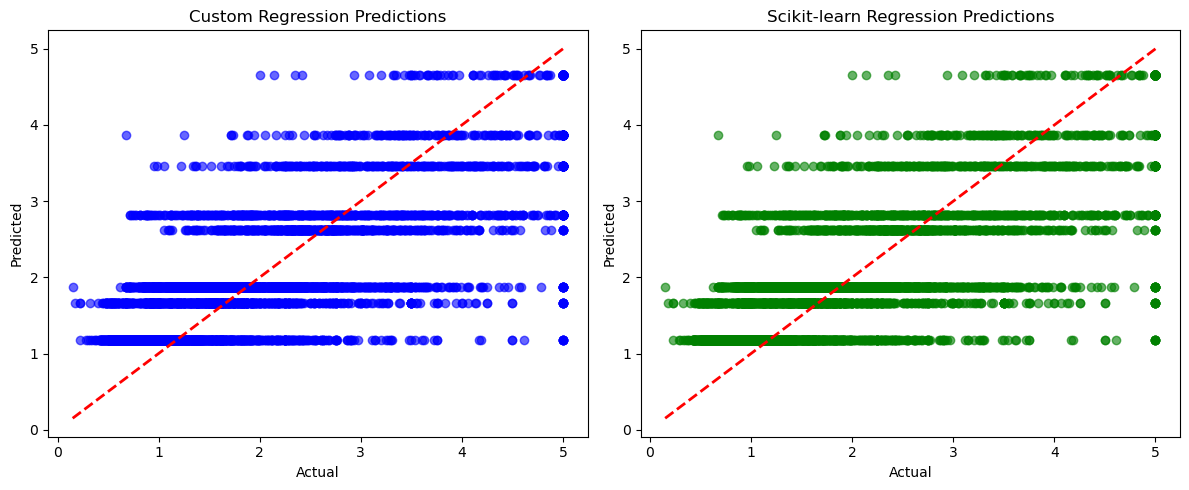

In [12]:
plot_regression_comparison(y_test,y_pred_my,y_pred_sk)

# Conclusion

The custom model performed well in both regression and classification tasks. On small datasets it achieved the same score as the scikit-learn models (100%), but on larger datasets it generally fell behind, except on the California housing dataset, where the difference was almost negligible. Some possible reasons for this gap are the randomness in feature selection and the lack of pruning in the current implementation.

Implementing this algorithm from scratch improved my understanding of how decision trees work “under the hood”: how the best split is computed (via information gain for classification and variance reduction for regression), and how the tree is recursively built by splitting nodes until a stopping criterion is reached.

Prediction is straightforward once the tree is built. We simply traverse the tree using the thresholds at each node until reaching a leaf, which gives the predicted label or value.